<div class="alert alert-info" style="background-color:#5d3a8e; color:white; padding:0px 10px; border-radius:5px;"><h1 style='margin:10px 5px'> 
Master Thesis Yannik Haller - Regression Analysis 1
</h1>
</div>

<div class="alert alert-info" style="background-color:#5d3a8e; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'> 
Preparation: load packages, set the appropriate working directory and load the data
</h2>
</div>

In [1]:
# Import required baseline packages
import re
import os
import glob
import time
import calendar
import sys
import pandas as pd
import numpy as np

# Change pandas' setting to print out long strings
pd.options.display.max_colwidth = 200

# Plotting tools
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
# Set global parameters for plotting
import matplotlib.pylab as pylab
params = {'legend.fontsize': 10,
          'figure.figsize': (8, 6),
          'axes.labelsize': 14,
          'axes.titlesize': 16,
          'xtick.labelsize': 10,
          'ytick.labelsize': 10}
pylab.rcParams.update(params)

# Regression and smoothing tools
import statsmodels.api as sm
import statsmodels.stats.diagnostic as ssd
from stargazer.stargazer import Stargazer
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import KFold

# Disable warnings
import warnings
warnings.filterwarnings("ignore", category = DeprecationWarning)
warnings.filterwarnings("ignore", category = FutureWarning)

In [2]:
# Set the appropriate working directory
os.chdir('D:\\Dropbox\\MA_data')

In [3]:
# Read in the sparse data as follows
articles = pd.read_csv("Analysis/articles_main_sparse.csv", index_col = 0)
# Transform publication_date into a daily date type
articles.publication_date = pd.to_datetime(articles.publication_date, yearfirst = True).astype('datetime64[D]')
# Transform the Topic_ID_2 into an integer type (not possible to read in as integer, due to missing values)
articles['Topic_ID_2'] = articles['Topic_ID_2'].astype("Int32")
# Take a look at the dataframe
articles

,source_short,source_long,publication_date,language,year,month,week,weekday,year_month,year_week,...,Topic_fine,Vader_polarity,Vader_polarity_adj,Vader_polarity_adj_2,Blob_polarity,weighted_stridx,weighted_dconfirmed_pm,weighted_ddeaths_pm,weighted_7dconfirmed_pm,weighted_7ddeaths_pm
0,AGE,Agefi,2020-10-01,fr,2020,10,39,Thursday,2020-10,2020-39,...,politics_international,0.9785,0.1582,0.1582,0.124348,40.256409,146.671235,1.706711,92.683854,0.487632
1,AGE,Agefi,2020-10-01,fr,2020,10,39,Thursday,2020-10,2020-39,...,economy_international,-0.7772,-0.1196,-0.1996,0.100000,40.256409,146.671235,1.706711,92.683854,0.487632
2,AGE,Agefi,2020-10-01,fr,2020,10,39,Thursday,2020-10,2020-39,...,economy_international,0.7561,0.0414,-0.0218,0.163700,40.256409,146.671235,1.706711,92.683854,0.487632
3,AGE,Agefi,2020-10-01,fr,2020,10,39,Thursday,2020-10,2020-39,...,economy_international,0.8078,0.0780,0.0780,-0.012364,40.256409,146.671235,1.706711,92.683854,0.487632
4,AGE,Agefi,2020-10-01,fr,2020,10,39,Thursday,2020-10,2020-39,...,economy_international,-0.8205,-0.0869,-0.1215,0.207273,40.256409,146.671235,1.706711,92.683854,0.487632
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2441178,ZWA,20 minuten,2021-01-22,de,2021,1,3,Friday,2021-01,2021-03,...,economy_national,0.9693,0.1817,0.1817,-0.100000,75.000000,245.907497,5.659186,228.809826,6.222238
2441179,ZWA,20 minuten,2021-01-22,de,2021,1,3,Friday,2021-01,2021-03,...,inconsequential,-0.7441,-0.0514,-0.0514,0.121429,75.000000,245.907497,5.659186,228.809826,6.222238
2441180,ZWA,20 minuten,2021-01-22,de,2021,1,3,Friday,2021-01,2021-03,...,sports,0.8391,0.2133,0.1293,0.350000,75.000000,245.907497,5.659186,228.809826,6.222238
2441181,ZWA,20 minuten,2021-01-22,de,2021,1,3,Friday,2021-01,2021-03,...,tragedies_crimes,-0.8689,-0.5667,-0.5667,-0.433333,75.000000,245.907497,5.659186,228.809826,6.222238


In [4]:
# Transform the Polarity scores Appropriately
### After appropriately combining the language-specific polarity scores of the VPA, VPAII, and BP into a single variable each, 
### rescale these sentiment measures to have a standard deviation of 1 (such that they are comparable to each other) and store them into the DF
## VPA
# Rescale the polarity scores and store the results in the Vader_polarity_adj_rsc variable
articles['Vader_polarity_adj'] = articles['Vader_polarity_adj'].copy()/np.std(articles['Vader_polarity_adj'])
## VPAII
# Rescale the polarity scores and store the results in the Vader_polarity_adj_2_rsc variable
articles['Vader_polarity_adj_2'] = articles['Vader_polarity_adj_2'].copy()/np.std(articles['Vader_polarity_adj_2'])
## BP
# Rescale the language-specific BPs prior to merging them
articles.loc[articles['language'] == 'de', 'Blob_polarity'] = (articles.loc[articles['language'] == 'de', 'Blob_polarity'].copy()/
                                                                                np.std(articles.loc[articles['language'] == 'de', 'Blob_polarity']))
articles.loc[articles['language'] == 'fr', 'Blob_polarity'] = (articles.loc[articles['language'] == 'fr', 'Blob_polarity'].copy()/
                                                                                np.std(articles.loc[articles['language'] == 'fr', 'Blob_polarity']))
articles.loc[articles['language'] == 'it', 'Blob_polarity'] = (articles.loc[articles['language'] == 'it', 'Blob_polarity'].copy()/
                                                                                np.std(articles.loc[articles['language'] == 'it', 'Blob_polarity']))
# Rescale the combined polarity scores again and store the results in the Blob_polarity_rsc variable
articles['Blob_polarity'] = articles['Blob_polarity'].copy()/np.std(articles['Blob_polarity'])

In [5]:
# Take a look at the size of the prepared data
sys.getsizeof(articles)

1845667922

In [6]:
# Take a look at some information concerning the articles dataframe
articles.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2439096 entries, 0 to 2441182
Data columns (total 28 columns):
 #   Column                   Dtype         
---  ------                   -----         
 0   source_short             object        
 1   source_long              object        
 2   publication_date         datetime64[ns]
 3   language                 object        
 4   year                     int64         
 5   month                    int64         
 6   week                     int64         
 7   weekday                  object        
 8   year_month               object        
 9   year_week                object        
 10  Topic_ID_1               int64         
 11  Affiliation_Prob_1       float64       
 12  Topic_ID_2               Int32         
 13  Affiliation_Prob_2       float64       
 14  Topic_1                  object        
 15  Topic_2                  object        
 16  Topic_ID_fine            float64       
 17  Affiliation_Prob_fine    fl

In [7]:
# Get the abbreviation of all newspapers that publish articles exclusively in German
de_src = []
for source in np.unique(articles['source_short']):
    n_lang = np.unique(articles.loc[articles['source_short'] == source, 'language'])
    if len(n_lang) == 1 and n_lang[0] == 'de':
        de_src.append(source)

# Get the abbreviation of all newspapers that publish articles exclusively in French
fr_src = []
for source in np.unique(articles['source_short']):
    n_lang = np.unique(articles.loc[articles['source_short'] == source, 'language'])
    if len(n_lang) == 1 and n_lang[0] == 'fr':
        fr_src.append(source)

# Get the abbreviation of all newspapers that publish articles exclusively in Italian
it_src = []
for source in np.unique(articles['source_short']):
    n_lang = np.unique(articles.loc[articles['source_short'] == source, 'language'])
    if len(n_lang) == 1 and n_lang[0] == 'it':
        it_src.append(source)

In [8]:
# Take a look at newspapers that publish articles in multiple languages
for source in np.unique(articles['source_short']):
    n_lang = np.unique(articles.loc[articles['source_short'] == source, 'language'], return_counts = True)
    if len(n_lang[0]) > 1:
        total_count = n_lang[1].sum()
        if len(n_lang[0]) == 2:
            string_to_print = n_lang[0][0]+' ('+str(np.round(n_lang[1][0]*100/total_count,3))+'%),\t'+n_lang[0][1]+' ('+\
                                                str(np.round(n_lang[1][1]*100/total_count,3))+'%)'
        if len(n_lang[0]) == 3:
            string_to_print = n_lang[0][0]+' ('+str(np.round(n_lang[1][0]*100/total_count,3))+'%),\t'+n_lang[0][1]+' ('+\
                                                str(np.round(n_lang[1][1]*100/total_count,3))+'%),\t'+n_lang[0][2]+' ('+\
                                                str(np.round(n_lang[1][2]*100/total_count,3))+'%)'
        print(source+' publishes articles in the following languages:\t'.expandtabs(55-len(source)) + string_to_print)

AZM publishes articles in the following languages:     de (99.989%),	fr (0.011%)
BAZ publishes articles in the following languages:     de (99.997%),	fr (0.003%)
BEOL publishes articles in the following languages:    de (99.994%),	fr (0.006%)
BIT publishes articles in the following languages:     de (99.954%),	fr (0.046%)
BLI publishes articles in the following languages:     de (99.996%),	fr (0.004%)
BT publishes articles in the following languages:      de (99.973%),	fr (0.027%)
BUET publishes articles in the following languages:    de (99.996%),	it (0.004%)
CASO publishes articles in the following languages:    de (99.999%),	fr (0.001%)
FN publishes articles in the following languages:      de (99.966%),	fr (0.034%)
INFS publishes articles in the following languages:    de (99.818%),	fr (0.182%)
LTZ publishes articles in the following languages:     de (99.987%),	fr (0.013%)
NNBS publishes articles in the following languages:    de (99.998%),	fr (0.002%)
NNHEU publishes articles in 

We observe that 78 out of the 96 distinct sources exclusively publish articles written in one language. Furthermore, for 17 out of the 18 sources that release articles in multiple languages, at least 98.5% of the publications are also written in the same language. Thus, we suspect that including fixed effects for the different languages and the different sources at the same time causes severe multicollinearity issues, since for each language one could construct a linear combination with the source inidcating dummies that highly correlates with the respective language indicating dummy. To prevent this issue we could either exclude language fixed effects or exclude source fixed effects. While the latter strategy would lead to conveniently interpretable results, the former would deliver more detailed (and thus more valuable) results. However, since the present analysis aims at revealing the difference between the reactions of the distinct sources, we decide to exclude language fixed effects in the following. However, as most sources tend to publish articles in only one langage, we decide to indicate the prevailing language of each source at the beginning of each source's abbreviation.

In [9]:
# Add the newspapers that publish predominantly German articles to the list of newspapers that publish exclusively in German
de_to_add = ['AZM', 'BAZ', 'BEOL', 'BIT', 'BLI', 'BT', 'BUET', 'CASO', 'FN', 'INFS', 'LTZ', 'NNBS', 'OLT', 'SOS', 'SOZM']
[de_src.append(src) for src in de_to_add]
# Add the newspapers that publish predominantly French articles to the list of newspapers that publish exclusively in French
fr_to_add = ['NNHEU', 'NNTDG']
[fr_src.append(src) for src in fr_to_add]
print('') # suppress output

In [10]:
# Indicate the according language for each source
for source in de_src:
    articles.loc[articles['source_short'] == source, 'source_short'] = 'de_'+source
for source in fr_src:
    articles.loc[articles['source_short'] == source, 'source_short'] = 'fr_'+source
for source in it_src:
    articles.loc[articles['source_short'] == source, 'source_short'] = 'it_'+source
articles.loc[articles['source_short'] == 'SWII', 'source_short'] = 'defrit_SWII'

In [11]:
# Take a look at the adjusted source abbreviations
np.unique(articles['source_short'])

array(['de_APPZ', 'de_AVU', 'de_AZM', 'de_BAZ', 'de_BEOL', 'de_BIT',
       'de_BIZO', 'de_BLI', 'de_BODU', 'de_BT', 'de_BU', 'de_BUET',
       'de_BZ', 'de_BZM', 'de_CASO', 'de_COOP', 'de_FN', 'de_FURT',
       'de_FUW', 'de_FUWO', 'de_GLAT', 'de_GP', 'de_INFS', 'de_LB',
       'de_LTZ', 'de_LUZ', 'de_MEWO', 'de_MM', 'de_NIW', 'de_NLZS',
       'de_NNBE', 'de_NNBS', 'de_NNBU', 'de_NNTA', 'de_NZZ', 'de_NZZS',
       'de_OAS', 'de_OBW', 'de_OLT', 'de_ONA', 'de_RUEM', 'de_SBAU',
       'de_SBLI', 'de_SEBO', 'de_SF', 'de_SGT', 'de_SHZ', 'de_SHZO',
       'de_SI', 'de_SOS', 'de_SOZM', 'de_SRF', 'de_TA', 'de_TAGZ',
       'de_TAM', 'de_TAS', 'de_TBT', 'de_TZ', 'de_URZ', 'de_VOLK',
       'de_WASO', 'de_WB', 'de_WEOB', 'de_WEW', 'de_WILB', 'de_WOZ',
       'de_ZHOL', 'de_ZHUL', 'de_ZOF', 'de_ZPLU', 'de_ZSZ', 'de_ZUGZ',
       'de_ZWA', 'de_ZWAO', 'defrit_SWII', 'fr_AGE', 'fr_ARC', 'fr_COOF',
       'fr_GHI', 'fr_HEU', 'fr_ILLE', 'fr_JJ', 'fr_LBH', 'fr_LIB',
       'fr_MME', 'fr_NNHEU', 'fr_N

<div class="alert alert-info" style="background-color:#5d3a8e; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'> 
1. Prepare the dataframe for the regression analysis
</h2>
</div>

In [12]:
# Remove columns that are not relevant for the regression analysis
articles.drop(['source_long','language','year','month','week','weekday','year_month','year_week','Topic_ID_1',
               'Affiliation_Prob_1','Topic_ID_2','Affiliation_Prob_2','Topic_1','Topic_2',
               'Topic_ID_fine','Affiliation_Prob_fine','Vader_polarity'], axis = 1, inplace = True)

In [13]:
# In order to economize computation of the subsequent models, we exploit the fact that the weighted Stringency index and weighted Covid metrics do not vary for a source within the same day
## Hence we reduce the dataframe to each source-day-topic combination, while retrieving the corresponding average polarity scores (VPA, VPAII, and BP) and frequencies. That is, for each source and each topic, 
## we count the number of articles the considered source published on each day on the focal topic, and compute the average polarity score among these articles.
## The number of articles is then used to weight each observation in the subsequent regression models
articles = articles.groupby(['source_short','Topic_fine','publication_date'])['Vader_polarity_adj', 'Vader_polarity_adj_2', 'Blob_polarity', 'weighted_stridx',
                                                                   'weighted_dconfirmed_pm', 'weighted_ddeaths_pm','weighted_7dconfirmed_pm', 'weighted_7ddeaths_pm'].mean().reset_index().merge(
    articles.groupby(['source_short','Topic_fine','publication_date'])['Vader_polarity_adj'].count().reset_index().rename(columns = {'Vader_polarity_adj': 'count'}), 
    how = 'inner', left_on = ['source_short','Topic_fine','publication_date'], right_on = ['source_short','Topic_fine','publication_date'], validate = "1:1")

# Take a look at the created dataframe
articles

,source_short,Topic_fine,publication_date,Vader_polarity_adj,Vader_polarity_adj_2,Blob_polarity,weighted_stridx,weighted_dconfirmed_pm,weighted_ddeaths_pm,weighted_7dconfirmed_pm,weighted_7ddeaths_pm,count
0,de_APPZ,COVID_economy,2019-02-02,0.689970,0.641458,-0.161747,0.000000,0.000000,0.000000,0.000000,0.000000,1
1,de_APPZ,COVID_economy,2019-02-06,-0.446321,-0.414940,2.062278,0.000000,0.000000,0.000000,0.000000,0.000000,1
2,de_APPZ,COVID_economy,2019-03-20,-0.110750,-0.102963,0.363931,0.000000,0.000000,0.000000,0.000000,0.000000,1
3,de_APPZ,COVID_economy,2019-04-13,-0.761403,-0.707869,-2.426209,0.000000,0.000000,0.000000,0.000000,0.000000,1
4,de_APPZ,COVID_economy,2019-05-09,1.721049,1.600042,-0.424587,0.000000,0.000000,0.000000,0.000000,0.000000,1
...,...,...,...,...,...,...,...,...,...,...,...,...
512308,it_ZWAI,transportation,2020-12-16,1.959519,1.821745,1.741135,61.666668,915.332160,40.104162,767.403266,26.641639,2
512309,it_ZWAI,transportation,2020-12-23,1.282541,1.117131,1.139605,72.469512,809.484930,11.485021,713.196048,16.806232,3
512310,it_ZWAI,transportation,2020-12-28,1.095387,0.794018,0.973308,72.469512,465.494770,22.907768,661.744109,19.209482,1
512311,it_ZWAI,transportation,2020-12-30,1.833062,1.704180,1.628772,72.469512,891.054364,25.701180,680.891317,22.065168,2


In [14]:
# Rename the source 'NZZ' such that it is chosen as a reference class later on
articles['source_short'].replace(['de_NZZ'], ['0_de_NZZ'], inplace = True)
# Rename the topic tragedies & crimes such that it is chosen as a reference class later on
## Note: we choose this topic as a reference class due to two reasons: 
### (1) the average polarity score is comparably low (such that FE coefficient of most other topics should be positive) 
### (2) the curve depicting the development of the topic's average polarity over time reveals that the polarity is comparably rather stable and not very strongly affected by changes in the stringency index
articles['Topic_fine'].replace(['tragedies_crimes'], ['0_tragedies_crimes'], inplace = True)

In [15]:
# Create a dataframe which suits the structure required in the regression analysis
## Add the numerical variables
reg_df_base = articles[articles.columns[3:]].copy()

## Add the categorical variables
### Note: We use one hot encoding to transform each categorical feature into an indicator variable for each category. To prevent multicollinearity issues, 
### we drop the first category of each discrete variable as a reference class

# Publication Date
reg_df_base = reg_df_base.merge(pd.get_dummies(articles['publication_date'], drop_first = True, prefix = 'date'),
                                how = 'inner', left_index = True, right_index = True, validate = "1:1") # Reference class: 2019-01-01
# Topic_fine
reg_df_base = reg_df_base.merge(pd.get_dummies(articles['Topic_fine'], drop_first = True, prefix = 'topic'), 
                                how = 'inner', left_index = True, right_index = True, validate = "1:1") # Reference class: tragedies & crimes
# Source
reg_df_base = reg_df_base.merge(pd.get_dummies(articles['source_short'], drop_first = True, prefix = 'src'),
                                how = 'inner', left_index = True, right_index = True, validate = "1:1") # Reference class: de_NZZ

# Take a look at the created dataframe
reg_df_base

,Vader_polarity_adj,Vader_polarity_adj_2,Blob_polarity,weighted_stridx,weighted_dconfirmed_pm,weighted_ddeaths_pm,weighted_7dconfirmed_pm,weighted_7ddeaths_pm,count,date_2019-01-02 00:00:00,...,src_fr_NNTDG,src_fr_NNTLM,src_fr_NOU,src_fr_RTS,src_fr_TDG,src_fr_TLMD,src_fr_TPS,src_fr_ZWAS,src_it_COOI,src_it_ZWAI
0,0.689970,0.641458,-0.161747,0.000000,0.000000,0.000000,0.000000,0.000000,1,0,...,0,0,0,0,0,0,0,0,0,0
1,-0.446321,-0.414940,2.062278,0.000000,0.000000,0.000000,0.000000,0.000000,1,0,...,0,0,0,0,0,0,0,0,0,0
2,-0.110750,-0.102963,0.363931,0.000000,0.000000,0.000000,0.000000,0.000000,1,0,...,0,0,0,0,0,0,0,0,0,0
3,-0.761403,-0.707869,-2.426209,0.000000,0.000000,0.000000,0.000000,0.000000,1,0,...,0,0,0,0,0,0,0,0,0,0
4,1.721049,1.600042,-0.424587,0.000000,0.000000,0.000000,0.000000,0.000000,1,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
512308,1.959519,1.821745,1.741135,61.666668,915.332160,40.104162,767.403266,26.641639,2,0,...,0,0,0,0,0,0,0,0,0,1
512309,1.282541,1.117131,1.139605,72.469512,809.484930,11.485021,713.196048,16.806232,3,0,...,0,0,0,0,0,0,0,0,0,1
512310,1.095387,0.794018,0.973308,72.469512,465.494770,22.907768,661.744109,19.209482,1,0,...,0,0,0,0,0,0,0,0,0,1
512311,1.833062,1.704180,1.628772,72.469512,891.054364,25.701180,680.891317,22.065168,2,0,...,0,0,0,0,0,0,0,0,0,1


In [16]:
# Transform the contained covid metrics from cases/deaths per million population to cases/deaths per 10K population
reg_df_base[reg_df_base.columns[4:8]] = reg_df_base[reg_df_base.columns[4:8]].copy() / 100
# Rename the modified columns accordingly
reg_df_base.rename(columns = {'weighted_dconfirmed_pm': 'weighted_dcases_p10k', 'weighted_ddeaths_pm': 'weighted_ddeaths_p10k', 
                    'weighted_7dconfirmed_pm': 'weighted_7dcases_p10k', 'weighted_7ddeaths_pm': 'weighted_7ddeaths_p10k', 'weighted_stridx': 'weighted_KOFSPI'}, inplace = True)

<div class="alert alert-info" style="background-color:#5d3a8e; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'> 
2. Main regressions 1 (RM1): Effect of the KOFSPI & number of daily confirmed Covid cases per 10K population on the articles' sentiments
</h2>
</div>

<div class="alert alert-info" style="background-color:#5d3a8e; color:white; padding:0px 10px; border-radius:5px;"><h3 style='margin:10px 5px'> 
2.1 Main Regressors: KOFPSI & daily confirmed covid cases per 10K population
</h3>
</div>

In [17]:
# Remove the articles dataframe to save memory
del articles

In [18]:
# Create interaction variables between the main regressors of interest (i.e. the weighted policy stringency index & the weighted daily confirmed covid cases per 10K population) and the topic indicating dummies to 
## reveal how strong the effects the main regressors have on the newpaper's sentiment (i.e. polarity score) differ across the different topics
reg_df = reg_df_base.copy()
# Stringency index
for col in reg_df.columns[749:776]:
    reg_df['KOFSPI_X_'+col] = reg_df['weighted_KOFSPI'].copy() * reg_df[col].copy()
# Cases
for col in reg_df.columns[749:776]:
    reg_df['casesp10k_X_'+col] = reg_df['weighted_dcases_p10k'].copy() * reg_df[col].copy()

In [19]:
## Get the feature variables to use in the regression
# Variables of interest
features = reg_df[['weighted_KOFSPI', 'weighted_dcases_p10k']].copy()
# Control variables
features = features.merge(reg_df[reg_df.columns[9:]], how = 'inner', left_index = True, right_index = True, validate = "1:1")
# Add a constant
features = sm.add_constant(features)

# Get the target variable / label
label = reg_df[['Vader_polarity_adj_2']].copy()
# Remove the reg_df dataframe to save memory
del reg_df

In [20]:
## Create the different feature selection sets to use subsequently
# Basic model without any fixed effects
selection_1 = [0,1,2]
# Add time fixed effects
selection_2 = selection_1.copy()
[selection_2.append(num) for num in np.arange(3,743)] # days
# Add cross-sectional fixed effects
selection_3 = selection_2.copy()
[selection_3.append(num) for num in np.arange(743,770)] # topics
[selection_3.append(num) for num in np.arange(770,865)] # sources
# Add interaction variables
selection_4 = selection_3.copy()
[selection_4.append(num) for num in np.arange(865,892)] # stridx x topics
[selection_4.append(num) for num in np.arange(892,919)] # casesp10k x topics
print('Done')

Done


In [21]:
### Estimate the desired linear regression models (RM1A, RM1B, RM1C)
# Estimate a first model using only the variables of interest (i.e. without controlling for fixed effects)
model_01 = sm.WLS(label, features[features.columns[selection_1]], weights = reg_df_base['count']).fit()
# Estimate a second model, in which additionally time fixed effects are considered
model_02 = sm.WLS(label, features[features.columns[selection_2]], weights = reg_df_base['count']).fit()
# Estimate a third model, in which additionally cross-sectional (topic & source) fixed effects are considered
model_03 = sm.WLS(label, features[features.columns[selection_3]], weights = reg_df_base['count']).fit()

In [22]:
# Perform Breusch-Pagan test for heteroskedasticity
bp_01 = ssd.het_breuschpagan(model_01.resid, features[features.columns[selection_1]])
bp_02 = ssd.het_breuschpagan(model_02.resid, features[features.columns[selection_2]])
bp_03 = ssd.het_breuschpagan(model_03.resid, features[features.columns[selection_3]])
print(bp_01)
print(bp_02)
print(bp_03)

# As we observe that H0 (i.e. Homoskedasticity) can be rejected with very high significance (as the p-values for the lagrange multiplier test as well as for the f-statistic are very low), 
# we decide to control for heteroskedastic standard errors in the subsequent regressions

(3089.270564490643, 0.0, 1553.9969088328296, 0.0)
(7042.899474947644, 0.0, 9.61012536379673, 0.0)
(35960.67552241032, 0.0, 44.68762713926755, 0.0)


In [21]:
### As we observe heterskedasticity we repeat the model estimation with heteroskedasticity robust standard errors
# Estimate a first model using only the variables of interest (i.e. without controlling for fixed effects)
model_01 = sm.WLS(label, features[features.columns[selection_1]], weights = reg_df_base['count']).fit(cov_type = 'HC3')
# Estimate a second model, in which additionally time fixed effects are considered
model_02 = sm.WLS(label, features[features.columns[selection_2]], weights = reg_df_base['count']).fit(cov_type = 'HC3')
# Estimate a third model, in which additionally cross-sectional (topic & source) fixed effects are considered
model_03 = sm.WLS(label, features[features.columns[selection_3]], weights = reg_df_base['count']).fit(cov_type = 'HC3')
# Estimate a fourth model, in which additionally interaction terms of interest are included (to reveal which topic is mainly driving the observed average effects from the models 1-3)
model_04 = sm.WLS(label, features[features.columns[selection_4]], weights = reg_df_base['count']).fit(cov_type = 'HC3')

In [22]:
# Take a look at the results of the models
stargazer = Stargazer([model_01, model_02, model_03, model_04])
stargazer.title('Effect of the KOFSPI & Daily Confirmed Covid Cases per 10K Population on VPAII')
stargazer.custom_columns(['RM1A', 'RM1B', 'RM1C', 'RM1D'], [1, 1, 1, 1])
stargazer.show_model_numbers(False)
stargazer.significant_digits(5)
coef_ordered = features.columns[selection_1].tolist()
stargazer.covariate_order(coef_ordered)
stargazer.show_degrees_of_freedom(False)
stargazer
#stargazer.render_latex()

# Note: Reference classes
## Topic_fine: tragedies & crimes
## Source:     de_NZZ
## Day:        2019-01-01

In [23]:
# Take a look at the coefficients on the interaction variables with the stringency index revealed by RM1D
stargazer = Stargazer([model_04])
stargazer.title('Effect of the KOFSPI & Daily Confirmed Covid Cases per 10K Population on VPAII')
stargazer.custom_columns(['RM1D'], [1])
stargazer.show_model_numbers(False)
stargazer.significant_digits(5)
cols = [selection_4[1]]
[cols.append(selection_4[n]) for n in np.arange(865,892)]
coef_ordered = features.columns[cols].tolist()
stargazer.covariate_order(coef_ordered)
stargazer.show_degrees_of_freedom(False)
stargazer

# Note: Reference classes
## Topic_fine: tragedies & crimes
## Source:     de_NZZ
## Day:        2019-01-01


### Interpretation example: the estimated average net impact of a 1 unit increase in the weighted stringency on the polarity (in terms of standard deviations) 
###                         of public health articles is given by the following coefficient composition:
### weighted_stridx + stridx_X_topic_public_health = -0.00020 - 0.00617 = -0.00637
### Note: Since the 'tragedies & crimes' topic serves as the reference class, the coefficient on weighted_stridx represents the average net impact of a 1 unit increase in the weighted stringency on the 
### polarity of tragedies & crimes articles (in terms of standard deviations).

In [24]:
# Take a look at the coefficients on the interaction variables with the daily confirmed covid cases per 10K population revealed by RM1D
stargazer = Stargazer([model_04])
stargazer.title('Effect of the KOFSPI & Daily Confirmed Covid Cases per 10K Population on VPAII')
stargazer.custom_columns(['RM1D'], [1])
stargazer.show_model_numbers(False)
stargazer.significant_digits(5)
cols = [selection_4[2]]
[cols.append(selection_4[n]) for n in np.arange(892,919)]
coef_ordered = features.columns[cols].tolist()
stargazer.covariate_order(coef_ordered)
stargazer.show_degrees_of_freedom(False)
stargazer

# Note: Reference classes
## Topic_fine: tragedies & crimes
## Source:     de_NZZ
## Day:        2019-01-01

### Interpretation example: the estimated average net impact of an increase by 1 in the daily confirmed covid cases per 10K population on the polarity (in terms of standard deviations) of articles concerning the 
### covid outbreak is given by the following coefficient composition: weighted_dcases_p10k + casesp10k_X_topic_COVID_outbreak_china = -0.00450 - 0.02111 = -0.02561
### Note: Since the 'tragedies & crimes' topic serves as the reference class, the coefficient on weighted_dcases_p10k represents the average net impact of an increase by 1 in the daily confirmed 
### covid cases per 10K population on the polarity of tragedies & crimes articles (in terms of standard deviations).

In [25]:
# Take a look at the cross-sectional fixed effects revealed by RM1C & RM1D
stargazer = Stargazer([model_03, model_04])
stargazer.title('Effect of the KOFSPI & Daily Confirmed Covid Cases per 10K Population on VPAII')
stargazer.custom_columns(['RM1C','RM1D'], [1, 1])
stargazer.show_model_numbers(False)
stargazer.significant_digits(5)
coef_ordered = features.columns[selection_3[743:]].tolist()
stargazer.covariate_order(coef_ordered)
stargazer.show_degrees_of_freedom(False)
stargazer

# Note: Reference classes
## Topic_fine: tragedies & crimes
## Source:     de_NZZ
## Day:        2019-01-01

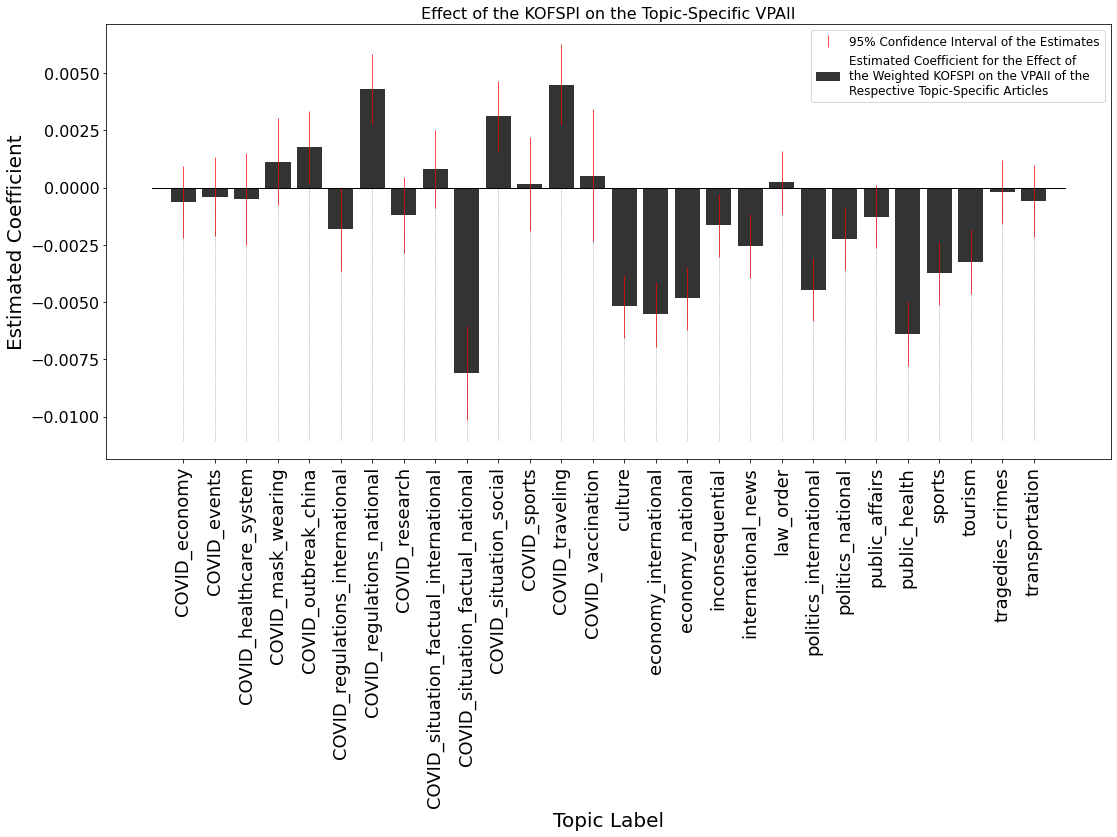

In [26]:
# Define a function to visualize the estimated coefficients for the effect of the KOFSPI on the topic-specific VPAII
topic_coeff = []
topic_label = []
topic_se    = []
topic_coeff.append(model_04.params.values[1])
topic_label.append('tragedies_crimes')
topic_se.append(model_04.bse.values[1])
[topic_coeff.append((coeff + topic_coeff[0])) for coeff in model_04.params.values[865:892]]
[topic_label.append(label[15:]) for label in model_04.params.index[865:892]]
cov_param = np.array(model_04.cov_params())
[topic_se.append(np.sqrt(topic_se[0]**2 + cov_param[i,i] + 2*cov_param[1,i])) for i in np.arange(865,892)]
# Reorder the variables topic_coeff, topic_label, and topic_se
topic_coeff[:26], topic_coeff[26] = topic_coeff[1:27], topic_coeff[0]
topic_label[:26], topic_label[26] = topic_label[1:27], topic_label[0]
topic_se[:26],    topic_se[26]    = topic_se[1:27],    topic_se[0]

fig = plt.figure(figsize = (18,8))
ax = fig.add_subplot(111)
x_pos = np.arange(len(topic_coeff))
ax.bar(x_pos, topic_coeff, align = 'center', color = 'black', alpha = 0.8, yerr = 1.96*np.array(topic_se), ecolor = 'red', error_kw = {'lw': 0.7, 'label': '95% Confidence Interval of the Estimates'},
      label = 'Estimated Coefficient for the Effect of\nthe Weighted KOFSPI on the VPAII of the\nRespective Topic-Specific Articles')
ax.plot([min(x_pos)-1,max(x_pos)+1], [0,0], color = 'black', linewidth = 1)
for i in range(len(x_pos)):
    plt.vlines(x_pos[i], -0.011, min(topic_coeff[i],0), colors = 'black', linestyles = 'dotted', alpha = 0.5, linewidth = 0.7)
ax.set_xticks(x_pos)
ax.set_xticklabels(topic_label, rotation = 90, ha = 'center', fontsize = 18)
ax.tick_params(axis = 'y', labelsize = 16)
ax.set_title('Effect of the KOFSPI on the Topic-Specific VPAII')
ax.set_xlabel('Topic Label', fontsize = 20)
ax.set_ylabel('Estimated Coefficient', fontsize = 20)
# Display the plot
ax.legend(loc = 'best', fontsize = 12)
plt.show()

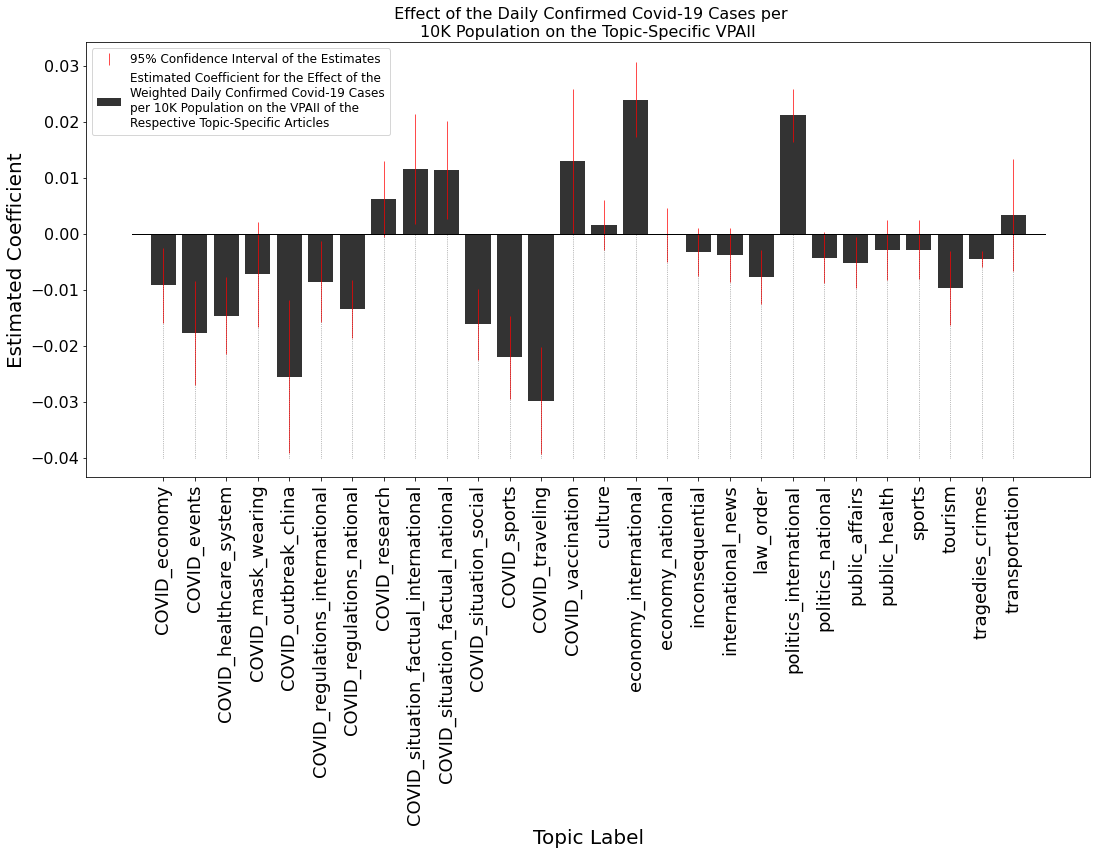

In [27]:
# Define a function to visualize the estimated coefficients for the effect of the daily confirmed Covid-19 cases per 10K population on the topic-specific VPAII
topic_coeff = []
topic_label = []
topic_se    = []
topic_coeff.append(model_04.params.values[2])
topic_label.append('tragedies_crimes')
topic_se.append(model_04.bse.values[1])
[topic_coeff.append((coeff + topic_coeff[0])) for coeff in model_04.params.values[892:919]]
[topic_label.append(label[18:]) for label in model_04.params.index[892:919]]
cov_param = np.array(model_04.cov_params())
[topic_se.append(np.sqrt(topic_se[0]**2 + cov_param[i,i] + 2*cov_param[1,i])) for i in np.arange(892,919)]
# Reorder the variables topic_coeff and topic_label
topic_coeff[:26], topic_coeff[26] = topic_coeff[1:27], topic_coeff[0]
topic_label[:26], topic_label[26] = topic_label[1:27], topic_label[0]
topic_se[:26],    topic_se[26]    = topic_se[1:27],    topic_se[0]

fig = plt.figure(figsize = (18,8))
ax = fig.add_subplot(111)
x_pos = np.arange(len(topic_coeff))
ax.bar(x_pos, topic_coeff, align = 'center', color = 'black', alpha = 0.8, yerr = 1.96*np.array(topic_se), ecolor = 'red', error_kw = {'lw': 0.7, 'label': '95% Confidence Interval of the Estimates'},
      label = 'Estimated Coefficient for the Effect of the\nWeighted Daily Confirmed Covid-19 Cases\nper 10K Population on the VPAII of the\nRespective Topic-Specific Articles')
ax.plot([min(x_pos)-1,max(x_pos)+1], [0,0], color = 'black', linewidth = 1)
for i in range(len(x_pos)):
    plt.vlines(x_pos[i], -0.04, min(topic_coeff[i],0), colors = 'black', linestyles = 'dotted', alpha = 0.5, linewidth = 0.7)
ax.set_xticks(x_pos)
ax.set_xticklabels(topic_label, rotation = 90, ha = 'center', fontsize = 18)
ax.tick_params(axis = 'y', labelsize = 16)
ax.set_title(' Effect of the Daily Confirmed Covid-19 Cases per\n10K Population on the Topic-Specific VPAII')
ax.set_xlabel('Topic Label', fontsize = 20)
ax.set_ylabel('Estimated Coefficient', fontsize = 20)
# Display the plot
ax.legend(loc = 'best', fontsize = 12)
plt.show()

<div class="alert alert-info" style="background-color:#5d3a8e; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'> 
3. Rocustness Check 1 (RC1): Effect of the KOFSPI & alternative Covid metrics on the articles' sentiments
</h2>
</div>

<div class="alert alert-info" style="background-color:#5d3a8e; color:white; padding:0px 10px; border-radius:5px;"><h3 style='margin:10px 5px'> 
3.1 Main Regressors: KOFSPI & 7 day average of daily confirmed covid cases per 10K population (RC1A)
</h3>
</div>

In [17]:
# Copy the baseline dataframe for the regression
reg_df = reg_df_base.copy()

## Get the feature variables to use in the regression
# Variables of interest
features = reg_df[['weighted_KOFSPI', 'weighted_7dcases_p10k']].copy()
# Control variables
features = features.merge(reg_df[reg_df.columns[9:]], how = 'inner', left_index = True, right_index = True, validate = "1:1")
# Add a constant
features = sm.add_constant(features)

# Get the target variable / label
label = reg_df[['Vader_polarity_adj_2']].copy()
# Remove the reg_df dataframe to save memory
del reg_df

## Create the different feature selection sets to use subsequently
# Basic model without any fixed effects
selection_1 = [0,1,2]
# Add time fixed effects
selection_2 = selection_1.copy()
[selection_2.append(num) for num in np.arange(3,743)] # days
# Add cross-sectional fixed effects
selection_3 = selection_2.copy()
[selection_3.append(num) for num in np.arange(743,770)] # topics
[selection_3.append(num) for num in np.arange(770,865)] # sources

# Estimate a model using the variables of interest while controlling for time (day) and cross-sectional (topic & source) fixed effects
model_05 = sm.WLS(label, features[features.columns[selection_3]], weights = reg_df_base['count']).fit(cov_type = 'HC3')

In [18]:
# Take a look at the results of the model
stargazer = Stargazer([model_05])
stargazer.title('Effect of the KOFSPI & 7-day Avg. of Daily Confirmed Covid Cases per 10K Population on VPAII')
stargazer.custom_columns(['RC1A'], [1])
stargazer.show_model_numbers(False)
stargazer.significant_digits(5)
coef_ordered = features.columns[selection_1].tolist()
stargazer.covariate_order(coef_ordered)
stargazer.show_degrees_of_freedom(False)
stargazer
#stargazer.render_latex()

# Note: Reference classes
## Topic_fine: tragedies & crimes
## Source:     de_NZZ
## Day:       2019-01-01

<div class="alert alert-info" style="background-color:#5d3a8e; color:white; padding:0px 10px; border-radius:5px;"><h3 style='margin:10px 5px'> 
3.2 Main Regressors: KOFSPI & daily confirmed covid deaths per 10K population (RC1B)
</h3>
</div>

In [19]:
# Copy the baseline dataframe for the regression
reg_df = reg_df_base.copy()

## Get the feature variables to use in the regression
# Variables of interest
features = reg_df[['weighted_KOFSPI', 'weighted_ddeaths_p10k']].copy()
# Control variables
features = features.merge(reg_df[reg_df.columns[9:]], how = 'inner', left_index = True, right_index = True, validate = "1:1")
# Add a constant
features = sm.add_constant(features)

# Get the target variable / label
label = reg_df[['Vader_polarity_adj_2']].copy()
# Remove the reg_df dataframe to save memory
del reg_df

## Create the different feature selection sets to use subsequently
# Basic model without any fixed effects
selection_1 = [0,1,2]
# Add time fixed effects
selection_2 = selection_1.copy()
[selection_2.append(num) for num in np.arange(3,743)] # days
# Add cross-sectional fixed effects
selection_3 = selection_2.copy()
[selection_3.append(num) for num in np.arange(743,770)] # topics
[selection_3.append(num) for num in np.arange(770,865)] # sources

# Estimate a model using the variables of interest while controlling for time (day) and cross-sectional (topic & source) fixed effects
model_06 = sm.WLS(label, features[features.columns[selection_3]], weights = reg_df_base['count']).fit(cov_type = 'HC3')

In [20]:
# Take a look at the results of the model
stargazer = Stargazer([model_06])
stargazer.title('Effect of the KOFSPI & Daily Covid Deaths per 10K Population on VPAII')
stargazer.custom_columns(['RC1B'], [1])
stargazer.show_model_numbers(False)
stargazer.significant_digits(5)
coef_ordered = features.columns[selection_1].tolist()
stargazer.covariate_order(coef_ordered)
stargazer.show_degrees_of_freedom(False)
stargazer
#stargazer.render_latex()

# Note: Reference classes
## Topic_fine: tragedies & crimes
## Source:     de_NZZ
## Day:       2019-01-01

<div class="alert alert-info" style="background-color:#5d3a8e; color:white; padding:0px 10px; border-radius:5px;"><h3 style='margin:10px 5px'> 
3.3 Main Regressors: KOFSPI & 7 day average of daily confirmed covid deaths per 10K population (RC1C)
</h3>
</div>

In [21]:
# Copy the baseline dataframe for the regression
reg_df = reg_df_base.copy()

## Get the feature variables to use in the regression
# Variables of interest
features = reg_df[['weighted_KOFSPI', 'weighted_7ddeaths_p10k']].copy()
# Control variables
features = features.merge(reg_df[reg_df.columns[9:]], how = 'inner', left_index = True, right_index = True, validate = "1:1")
# Add a constant
features = sm.add_constant(features)

# Get the target variable / label
label = reg_df[['Vader_polarity_adj_2']].copy()
# Remove the reg_df dataframe to save memory
del reg_df

## Create the different feature selection sets to use subsequently
# Basic model without any fixed effects
selection_1 = [0,1,2]
# Add time fixed effects
selection_2 = selection_1.copy()
[selection_2.append(num) for num in np.arange(3,743)] # days
# Add cross-sectional fixed effects
selection_3 = selection_2.copy()
[selection_3.append(num) for num in np.arange(743,770)] # topics
[selection_3.append(num) for num in np.arange(770,865)] # sources

# Estimate a model using the variables of interest while controlling for time (day) and cross-sectional (topic & source) fixed effects
model_07 = sm.WLS(label, features[features.columns[selection_3]], weights = reg_df_base['count']).fit(cov_type = 'HC3')

In [22]:
# Take a look at the results of the model
stargazer = Stargazer([model_07])
stargazer.title('Effect of the KOFSPI & 7-day Avg. of Daily Covid Deaths per 10K Population on VPAII')
stargazer.custom_columns(['RC1C'], [1])
stargazer.show_model_numbers(False)
stargazer.significant_digits(5)
coef_ordered = features.columns[selection_1].tolist()
stargazer.covariate_order(coef_ordered)
stargazer.show_degrees_of_freedom(False)
stargazer
#stargazer.render_latex()

# Note: Reference classes
## Topic_fine: tragedies & crimes
## Source:     de_NZZ
## Year:       2019-01-01

<div class="alert alert-info" style="background-color:#5d3a8e; color:white; padding:0px 10px; border-radius:5px;"><h3 style='margin:10px 5px'> 
3.4 Compare the main outcomes of the RC1 models to each other
</h3>
</div>

In [23]:
# Take a look at the results of the models from RC1
stargazer = Stargazer([model_05, model_06, model_07])
stargazer.title('Effect of the KOFSPI & 7-day Avg. of Daily Covid Cases per 10K Population, daily reported Covid-19 fatalities per 10K Population, or the corresponding 7-day average on VPAII')
stargazer.custom_columns(['RC1A', 'RC1B', 'RC1C'], [1, 1, 1])
stargazer.show_model_numbers(False)
stargazer.significant_digits(5)
coef_ordered = ['const', 'weighted_KOFSPI', 'weighted_7dcases_p10k', 'weighted_ddeaths_p10k', 'weighted_7ddeaths_p10k']
stargazer.covariate_order(coef_ordered)
stargazer.show_degrees_of_freedom(False)
stargazer
#stargazer.render_latex()

# Note: Reference classes
## Topic_fine: tragedies & crimes
## Source:     de_NZZ
## Year:       2019-01-01